# Install Dependencies

In [1]:
!pip install -q librosa transformers openai-whisper pydub scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s et

# Import Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import whisper
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from IPython.display import Audio, display

# Download Sample Audio

In [3]:
!mkdir -p data/audio
!wget -P data/audio https://www.openslr.org/resources/12/test-clean.tar.gz
!tar -xvzf data/audio/test-clean.tar.gz -C data/audio

--2025-04-14 09:14:00--  https://www.openslr.org/resources/12/test-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://openslr.elda.org/resources/12/test-clean.tar.gz [following]
--2025-04-14 09:14:01--  https://openslr.elda.org/resources/12/test-clean.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346663984 (331M) [application/x-gzip]
Saving to: ‘data/audio/test-clean.tar.gz’

test-clean.tar.gz   100%[===================>] 330.60M  22.2MB/s    in 17s     

2025-04-14 09:14:18 (19.7 MB/s) - ‘data/audio/test-clean.tar.gz’ saved [346663984/346663984]

LibriSpeech/LICENSE.TXT
LibriSpeech/README.TXT
LibriSpeech/CHAPTERS.TXT
LibriSpeech/SPEA

#  Find audio files in extracted folder

In [4]:
import glob
audio_files = glob.glob('data/audio/LibriSpeech/test-clean/**/*.flac', recursive=True)[:5]

# Initialize Whisper Model

In [5]:
model = whisper.load_model("base")

100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 54.7MiB/s]


# Feature Extraction Function

In [6]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    duration = librosa.get_duration(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0])
    pitch_std = np.std(pitches[pitches > 0])

    # Transcription
    result = model.transcribe(file_path)
    text = result["text"]

    # NLP Features
    words = text.split()
    speech_rate = len(words) / (duration / 60)
    hesitation_markers = sum(word.lower() in ["uh", "um", "erm"] for word in words)
    pause_segments = [seg for seg in result.get("segments", []) if seg['end'] - seg['start'] > 0.3]
    pauses_per_sentence = len(pause_segments) / max(1, text.count("."))

    return {
        "file": os.path.basename(file_path),
        "duration_sec": duration,
        "speech_rate_wpm": speech_rate,
        "hesitation_count": hesitation_markers,
        "pauses_per_sentence": pauses_per_sentence,
        "pitch_mean": pitch_mean,
        "pitch_std": pitch_std,
        "text": text
    }

# Extract Features for All Files

In [7]:
features = [extract_features(f) for f in audio_files]
df = pd.DataFrame(features)
df_numeric = df.drop(columns=["file", "text"])

/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [11]:
df.head()

,file,duration_sec,speech_rate_wpm,hesitation_count,pauses_per_sentence,pitch_mean,pitch_std,text,risk_score
0,2961-961-0016.flac,7.815,168.905950,0,2.0,1635.354126,1140.245483,"I will briefly describe them to you, and you shall read the account of them at your leisure in ...",-1
1,2961-961-0001.flac,9.185,156.777354,0,1.0,1624.648682,1241.208618,And now he desires to see the ideal state set in motion. He would like to know how she behaved ...,-1
2,2961-961-0021.flac,4.940,182.186235,0,1.0,1559.903564,1094.322510,But I would not speak at the time because I wanted to refresh my memory.,-1
3,2961-961-0013.flac,5.120,117.187500,0,1.0,1514.354492,1044.609131,Salon marveled and desired to be informed of the particulars.,-1
4,2961-961-0004.flac,11.480,141.114983,0,1.5,1369.235962,1072.809937,"Listen then, Socrates, to a tale of solace. Who, being the friend of Drobidus, my great grandfa...",1


In [12]:
df_numeric.head()

,duration_sec,speech_rate_wpm,hesitation_count,pauses_per_sentence,pitch_mean,pitch_std
0,7.815,168.905950,0,2.0,1635.354126,1140.245483
1,9.185,156.777354,0,1.0,1624.648682,1241.208618
2,4.940,182.186235,0,1.0,1559.903564,1094.322510
3,5.120,117.187500,0,1.0,1514.354492,1044.609131
4,11.480,141.114983,0,1.5,1369.235962,1072.809937


# Normalize and Apply Unsupervised Anomaly Detection

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)
model_if = IsolationForest(contamination=0.2)
df["risk_score"] = -model_if.fit_predict(X_scaled)

# Visualizations

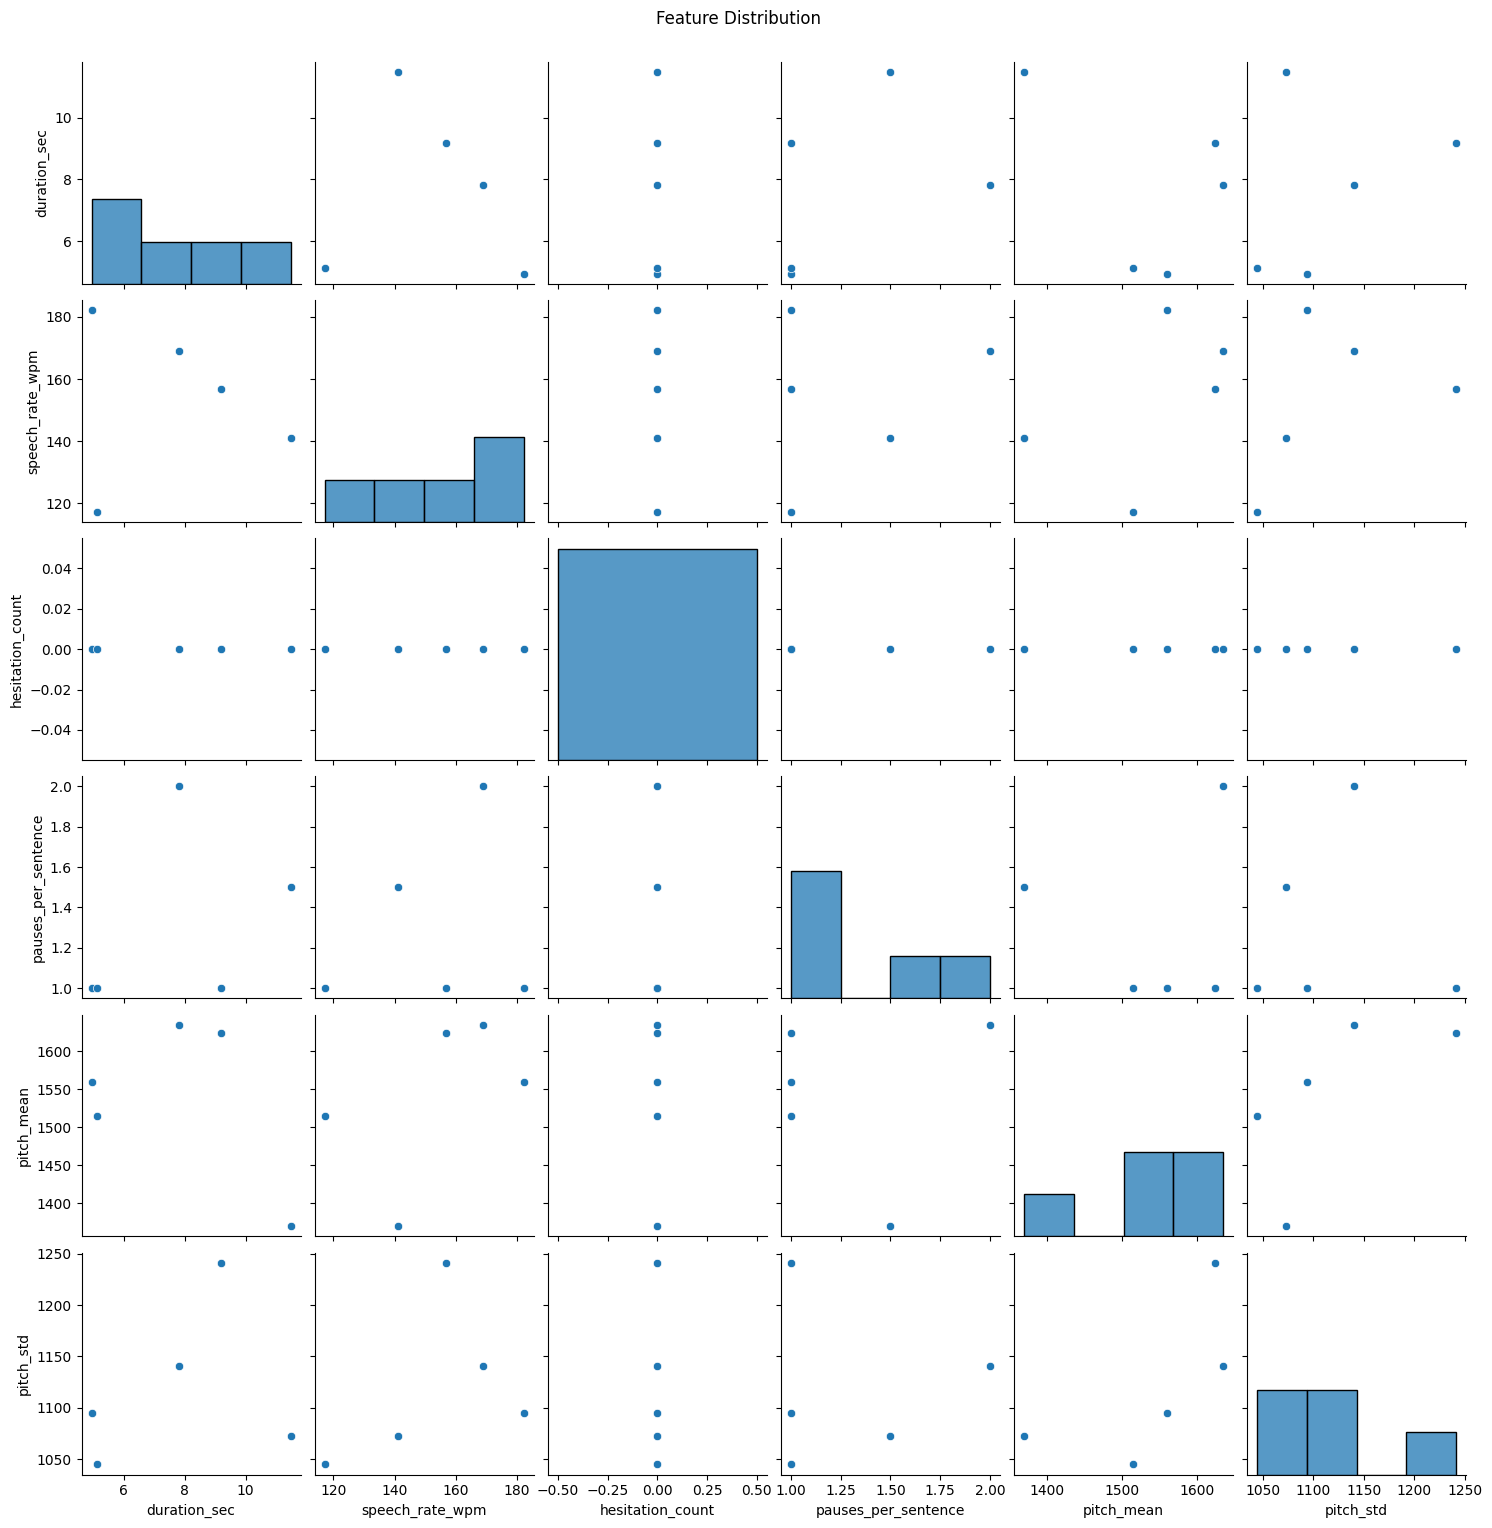

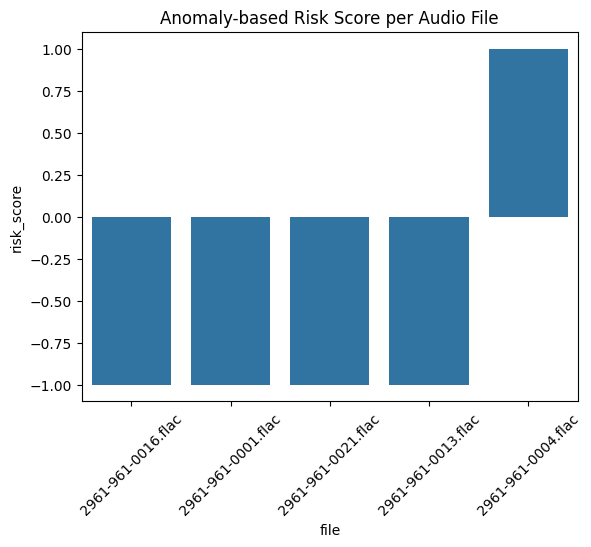

In [9]:
sns.pairplot(df_numeric)
plt.suptitle("Feature Distribution", y=1.02)
plt.show()

sns.barplot(x="file", y="risk_score", data=df)
plt.title("Anomaly-based Risk Score per Audio File")
plt.xticks(rotation=45)
plt.show()

# Results

In [10]:
pd.set_option('display.max_colwidth', 100)
display(df[["file", "risk_score", "speech_rate_wpm", "hesitation_count", "pauses_per_sentence", "pitch_std"]])

,file,risk_score,speech_rate_wpm,hesitation_count,pauses_per_sentence,pitch_std
0,2961-961-0016.flac,-1,168.905950,0,2.0,1140.245483
1,2961-961-0001.flac,-1,156.777354,0,1.0,1241.208618
2,2961-961-0021.flac,-1,182.186235,0,1.0,1094.322510
3,2961-961-0013.flac,-1,117.187500,0,1.0,1044.609131
4,2961-961-0004.flac,1,141.114983,0,1.5,1072.809937
